In [67]:
import matplotlib.pyplot as plt
from pyscf import gto, scf
import numpy as np

In [68]:
def f_score(S, final, initial) -> float:
    Da_guess, Db_guess = initial, initial
    Da_ref, Db_ref = final, final

    Q = lambda P_guess, P_ref: np.sum(P_guess * (S @ P_ref @ S))
    N = lambda P_ref: np.sum(P_ref * S)

    numerator = Q(Da_guess, Da_ref) + Q(Db_guess, Db_ref)
    denominator = N(Da_ref) + N(Db_ref)

    return numerator / denominator

In [69]:
mol = gto.M(
    atom="geometries/hoclo.xyz",
    basis= "sto-3g", #" pcseg-0",
    spin=0,
    symmetry=False,
)

In [70]:
# Run Hartree-Fock calculation to obtain a converged density
mf = scf.RHF(mol).density_fit().run()
print(f"Final energy: {mf.energy_tot()} Ha")

mo1, _, stable, _ = mf.stability(return_status=True)
while not stable:
    dm1 = mf.make_rdm1(mo1, mf.mo_occ)
    mf = mf.run(dm1)
    mo1, _, stable, _ = mf.stability(return_status=True)

# Factor two to account for double occupation
final_dm = mf.make_rdm1() / 2
print(f"Aux basis set used: {mf.with_df.auxmol.basis}")

converged SCF energy = -602.487924425428
Final energy: -602.4879244254275 Ha
<class 'pyscf.df.df_jk.DFRHF'> wavefunction is stable in the internal stability analysis
Aux basis set used: {'Cl': 'def2-svp-jkfit', 'H': 'def2-svp-jkfit', 'O': 'def2-svp-jkfit'}


In [71]:
def build_guess(guess="1e"):
    mf = scf.RHF(mol)
    guess_dens = mf.get_init_guess(key=guess)
    # Factor two to account for double occupation
    return guess_dens / 2

In [72]:
[*[1]*(5+2), 0.05]

[1, 1, 1, 1, 1, 1, 1, 0.05]


WARN: Fail in reading /tmp/tmp439mqf3e. Use MINAO initial guess



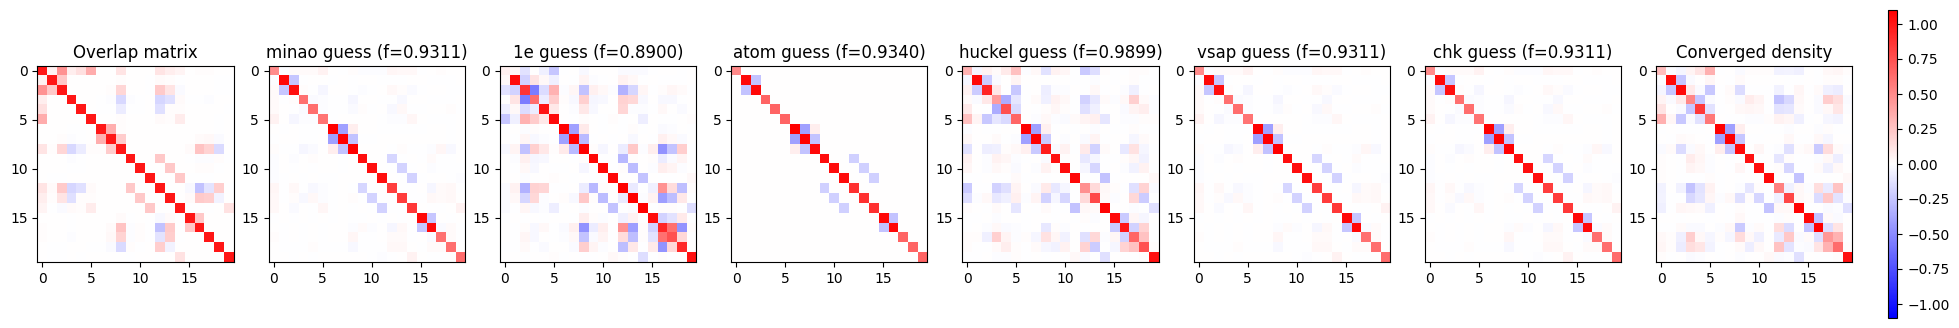

In [73]:
S = mf.get_ovlp()
# Similar to SAD guess
guesses = ["minao", "1e", "atom", "huckel", "vsap", "chk"]
guess_densities = []
for guess in guesses: 
    guess_densities.append(build_guess(guess))

imshow_kwargs = dict(vmin=-1.1, vmax=1.1, cmap="bwr")
fig, ax = plt.subplots(figsize=(3*(len(guesses)+2), 4), ncols=len(guesses)+3, width_ratios=[*[1]*(len(guesses)+2), 0.05])
ax[0].imshow(S, **imshow_kwargs)
ax[0].set_title("Overlap matrix")

for i, guess_dm in enumerate(guess_densities):
    ax[i+1].imshow(guess_dm, **imshow_kwargs)
    ax[i+1].set_title(f"{guesses[i]} guess (f={f_score(S, final_dm, guess_dm):.4f})")


p = ax[len(guesses)+1].imshow(final_dm, **imshow_kwargs)
ax[len(guesses)+1].set_title("Converged density")

plt.colorbar(p, cax=ax[-1])

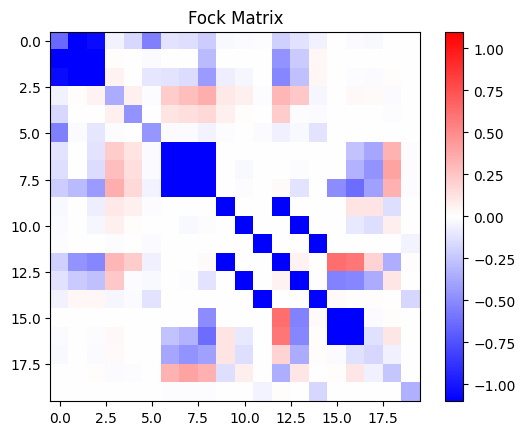

In [74]:
fock_end = mf.get_fock()
fig, ax = plt.subplots()
cax = ax.imshow(fock_end, **imshow_kwargs)
fig.colorbar(cax)
ax.set_title("Fock Matrix")
plt.show()

# Different initial guesses

Lets try to reproduce the corresponding row from Supporting Information Table S5:

| Molecule | GWH   | CORE  | SAD   | SADNO | HUCKEL | GSZ   | LDA-X | CAP-X | CHA-X |  
| -------- | ----- | ----- | ----- | ----- | ------ | ----- | ----- | ----- | ----- |
| hoclo    | 0.628 | 0.740 | 0.936 | 0.977 | 0.984  | 0.974 | 0.994 | 0.993 | 0.994 |

In [75]:
# All available initial guess options in pyscf
# (from: https://github.com/pyscf/pyscf/blob/9a0bb6ddded7049bdacdaf4cfe422f7ce826c2c7/pyscf/scf/hf.py#L1940)
guesses = ["minao", "hcore", "huckel", "mod_huckel", "atom", "sap"]
for guess in guesses:
    guess_dm = build_guess(guess=guess)
    f = f_score(S, final_dm, guess_dm)
    print(f"{guess:>10s}: {f:.3f}")

     minao: 0.931
     hcore: 0.890
    huckel: 0.990
mod_huckel: 0.987
      atom: 0.934
Found SAP basis sapgrasplarge
       sap: 0.990
